<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.5: Learning Behaviour Quickly**

### Objective: Investigate a new, simple optimization procedure with clear physiological interpretation.

In this sequence we will:

* Continue to work with the strike-no-strike problem where the decision depends on 64 sensory inputs (features) to investigate more rapid plasticty rules.

* Compare these new plasticity rules to perturb-measure-step both in terms of learning rate and physilogical plausibility.

* Understand the efficacy of these new learning rules using an optimization perspective.

* Test these new learning rules on a harder learning problem, still with 64 sensory features, but now with 10 possible behavioural responses. Note how scale affects the problem.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S5"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.4.1 Learning Strike-No-Strike Quickly

Recall from the previous sequence that the cartoon organism that inspires this problem can be thought of as having 64 photo-sensitive receptors, and based on the combination of inputs from these receptors it must decide whether to strike or not. The organism pays a cost of one if it strikes when it shouldn't (prey is absent) and recieves a reward of one if it strikes when it should (prey is present). It receives no cost or reward when it does not strike. To get a sense of this discrimination problem try it yourself by running the code cell below.

In [2]:
# @markdown **Run this cell** to try out the more complex 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y1,
               extra_labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    #sample_order = np.arange(self.features.shape[0])
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    self.extra_labels = extra_labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.current_image = None
    self.previous_image = None
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    current_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]

    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    if self.current_image is not None:
      self.previous_image = self.current_image
    image = np.flipud(image)
    self.current_image = image
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(self.current_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    if self.previous_image is not None:
      self.prev_ax.imshow(self.previous_image, cmap='gray', vmin=-6, vmax=6, origin='upper')
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      #print(self.labels[self.current_index])
      #print(self.extra_labels[self.current_index])
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
display(scramble_bin_hard.prev_fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

We model this creature's sensory-behaviour system as follows, $\mathbf{x}$ is the raw sensory input (column vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level of a single photosensitive neuron. We visualize an example sensory input as an $8 \times 8$ grid in the code cell below.

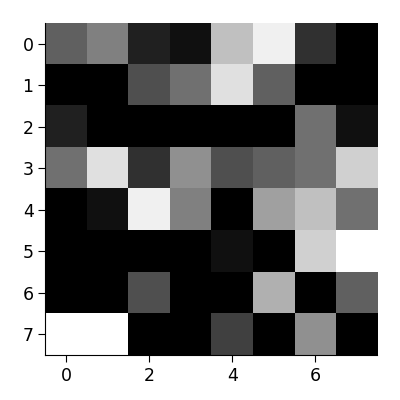

In [3]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level, $z$, of this output neuron is computed as
$$z = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  

To simplify exposition and coding the input $\mathbf{x}$ is augmented to have a feature which is always 1, and then the bias terms can be treated as the weight connecting to this constant valued feature. That is

$$z = \mathbf{Wx}$$

And now $\mathbf{W}$ has shape 1x65. The probability of striking is determined by the activation level of the output neuron, together with a temperature parameter $\tau$ which determines how exploratory the behaviour of the organism is, specifically:
$$ \Pr \{\text{strike}\} = \sigma_{\tau}(z) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma_{\tau}(z)$$

Here $$\sigma(a): \frac{1}{1+e^{\frac{-z}{\tau}}} = \frac{e^{\frac{z}{\tau}}}{1+e^\frac{z}{\tau}}$$ is the logistic (sigmoid) function, with temperature parameter $\tau$. High values of $\tau$ make striking and not striking have nearly equal probability regardless of the value of $z$, whereas very low values of $\tau$ mean that even a very slightly positive $z$ value will correspond to near certainty of striking, and a very slight negative value will result in an almost certain chance of not striking. In other words $\tau$ determines how responsive the striking probabilities are to changes in $z$.

Instead of thinking of $z$ as simply just a way of determining the striking probability, we could also treat $z$ as a kind of prediction or expectation of the reward that will occur if the striking action is taken given the current sensory experience $\mathbf{x}$. If there is a higher expectation of reward, the probability of taking the striking action increases, if there is a lower expectation of reward the probability of taking the striking action decreases, according the the temperature scaled softmax function above.

Taking this perspective, where $z$ as the organism's internal representation of the expected reward when taking the striking action, then the organism could compare its expectation of reward with the reward actually receives, and use the difference between expectation and reality to update the synaptic weights that had a causal impact on this expectation in such a way that the expected reward more closely aligns with the received reward. Given our simple network a rule that does this is:

## Reward-Prediction-Error Episodic Update Rule

$$\Delta W_i = s \cdot (r-z) \cdot x_i $$

Or in vector form

$$ \Delta \mathbf{W} = s \cdot (r-z) \cdot \mathbf{x}$$


This is saying that if the received reward is greater than the predicted reward, then it would be better if $a$ had been larger, which means that in the cases where $x_i$ was positive, the weight from $x_i$ should be increased, in proportion to the strength of activation of $x_i$ and in the case that $x_i$ was negative, the weight from $x_i$ should be decreased, again in proportion to the strength of the activation of $x_i$. Conversely if, the reward received is less than predicted then it would have been better if $a$ was smaller and so, in the case where $x_i$ is positive the weight from $x_i$ should be decreased, in proportion to the strength of the activation of $x_i$ and in the case that $x_i$ is negative, the weight from $x_i$ should be decreased. (Note that in the vector formulation above that should technically be $\mathbf{x}^T$ since $\mathbf{x}$ is column vector (64, 1) whereas $\mathbf{W}$ is a row vector (1, 64), and the shape and orientation of $\Delta \mathbf{W}$ should match the shape of $\mathbf{W}$.)

This rule can be understood as shifting the weights $\mathbf{W}$ in the direction that minimizes the squared error of the reward prediction.

$$ z = \mathbf{W}\mathbf{x}$$
$$\begin{align} \nabla_\mathbf{W} (r-z)^2 & = 2 \ (r-z) \ \nabla_{\mathbf{W}}z \\
& = 2 (r-z) \mathbf{x}
\end{align}$$
The factor of 2 is subsumed in the step scaling factor $s$.

We call this an episodic update rule because it can concievably be implemented after a single experience of sensory input, action selection, and resultant reward.

Under one version of this updating scheme, let's call it the "realishtic" version, no update is made to the network if the organism refrains from striking. In this scenario this prediction pertains to the reward when striking, so this difference between expected and received reward simply does not apply to the case where no striking occurs. Note that the $\tau$ parameter in the sigmoid, striking probability function determines how exploratory the behaviour is independently of the prediction. $\tau$ is very important. During the earlier episodes of the organism's life it should be more exploratory (higher $\tau$), but once it has learned good predictions of reward across a representative range of experiences it can settle into simply exploiting the knowledge it has (lower $\tau$). Deciding when and how to transition from exploratory behaviours to more directly reward maximizing behaviours is known as an exploration-exploitation trade-off, and is a central challenge in Reinforcement Learning. We just mention this in passing now, but will dive more deeply into the exploration-exploitation tradeoff in sequence (blah).

Under another version of this scheme, let's call it the "cheating" version, an update is always made based on the $r_{\text{strike}}$, the reward the organism would have recieved if it strikes, regardless of whether it actually strikes or not, i.e. it gets to know what the right answer was regardless of what action it takes. This could be implemented by the organism having some additional, post-hoc prey detection that augments the organism's basic behavioural inputs with additional teaching signals. These additional signals allow the organism to learn from situations where it's like "Oh I wish I had struck at the food that is now swimming past me" and also situations where it's like "Oh there really was no food there, good thing I didn't strike". Such mechanism likely exist, but are more complex than the simple case of reinforcing actions taken based on intrinsic reward recieved. Our focus for now is this simple case. (We could approximate such a system by "rewarding" not striking when no prey is present with 1 and giving a penalty of 1 when an organism fails to strike when prey is present, but this leaves open the question of if and how such "learning scaffolding" rewards need to be and can be kept seperate from 'actual' rewards that count towards fitness in the evolutionary sense. This is a complex topic that we will revist throught the book, in particular in sequences (ref)).

From an evolutionary and adaptive behaviour perspective we are interested in how the organism can quickly learn to take rewarding actions. This suggest an alternative updating scheme where the reward recieved directly reinforces the probability of taking the action that produced it. To do this we need know how a change in $z$ translates into an increase (or decrease) in the probability of striking, so that we can increase (decrease) action probabilites in proportion to the rewards recieved as a result of particular action choices. We call this the Action-Probability-Reinforcement update rule

## Action Probability Reinforcement Episodic Update Rule

$$ \Delta W_i = s \cdot r \cdot \sigma'(z) \cdot x_i$$

or in vector form

$$ \Delta \mathbf{W} = s \cdot r \cdot \sigma'(z) \cdot \mathbf{x}$$

Here $\sigma'$ is the derivative of the sigmoid function. We no longer need to explicitly control exploration versus exploitation with $\tau$, so we simply set $\tau =1$ here for simplicity. The above rule uses the raw rewards to reinforce actions. The probability of striking is given by $\sigma(a)$ so the way to change $\mathbf{W}$ to increase the probability of striking is to shift the weights in the direction of the gradient of the probability of taking the action given by $\sigma'(a)$. Using the defination of $\sigma$ above and the chain rule from calculus we can derive that $\sigma'(a) = \sigma(a) (1-\sigma(a))$. This is telling us what we already know intuitively about the sigmoid function, which is that it is relatively flat when probalities are close to zero or one, and steepest when probabilities are close to even, that is 0.5.

The above rule can be understood as shifting weights $\mathbf{W}$ so that the probability of striking in a particular instance ($\mathbf{x}$) is increased (or decreased in the case of negative reward) in proportion to the rewards that result from taking the striking action.
$$ \Pr\{\text{strike}|\mathbf{x}\} = \sigma(\mathbf{W}\mathbf{x})$$
$$\begin{align} \Delta \mathbf{W} &= s \cdot \nabla_\mathbf{W} \Pr\{\text{strike}| \mathbf{x}\} \cdot r \\
& = s \cdot \sigma'(z) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \cdot r \\
& = s \cdot \sigma'(z) \cdot \mathbf{x} \cdot r \\
& = s \cdot \sigma(z) (1 - \sigma(z)) \cdot \mathbf{x} \cdot r
\end{align}$$

Again we call this an episodic update rule because it can concievably be applied after a single episode or experience consisting ot a sensory experience, a selection of action, and a resultant reward.

Again, this rule also has a realishtic and a cheating variant. The realishtic variant uses the actual reward $r$ obtained from sampling an action, and experiencing the subsequent reward. However, in the cheating variant (often used in ML contexts) learning is greatly accelerated by using the expected reward $\mathbb{E}[r]$ given the probability distribution over possible actions instead of utilizing a particular sample from the distribution of possible actions and the particular resultant reward. This cheating variant is only episodic if it is able to somehow consider all possible actions and all possible outcomes within that single episode, certainly possible, but adds the complexity of trying to learn from hypothetical outcomes, much as in the cheating version of Reward-Prediction-Error update rule.




Complete the coding exercise below to see how these two different udpated rules compare with our perturb-measure-step rule, both in our realishtic and cheating variants. Note the that the `eval_params` function we use below can be thought of as containing both an action selection component that depends on the sensory inputs $\mathbf{x}$ and the parameters $\mathbf{W}$ and then a reward component that calculates the appropriate reward given some (as yet unobserved by organisms) aspect of the environment encoded in $y$ and the action selected.

In [4]:
################################################################################
# TODO for students: Replace ... in the lines below with one of the following
# options, each option get's used exactly once
# a) r * (strike_prob) * (1 - strike_prob) * x
# b) (r_all - z) * x
# c) (np.mean(r_perturb - r)) / perturbation_scale
# d) r_exp * (strike_prob) * (1 -  strike_prob) * x
# e) (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
# f) (r-z) * strike * x
# This will implement different update rules driven by: Reward Prediction Error,
# Reinforcement of Action ProbabilitiesTrue Positives, or Peturb-Measure
# estimate of the gradient of expected reward. Both in a strict, experience
# driven way, and in "cheating" a bit way.
raise NotImplementedError("Exercise: Implement different update rules to compare")
################################################################################

def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)
  strike_prob = np_sigmoid(z, tau)
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-out_spike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           cheat=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.0001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn regardless of whether organism actually strikes or not
    update = ...
  else: #realishtic
    # learn only from actual recieved rewards
    update = ...
  # average the update over all elements in the batch
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y,
                     cheat=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = ...
  else: #realishtic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = ...
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.01,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if cheat:
    # evaluate perturbation using expected reward, avg over the mini-batch
    directional_grad_est = ...
  else: #realishtic
    # evaluate perturbation using sampled rewards, avg over the mini-batch
    directional_grad_est = ...
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

################################################################################
# Exercise Complete, simulations and plotting logic follow
################################################################################
# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
cheat_alg_lrs = {'Reward Prediction': 0.0001,
                 'Action Probability': 0.008,
                 'Perturb Measure': 0.0016}
cheat_actual_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      cheat_actual_reward_results[alg_name].append(np.mean(r))
      cheat_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break
# plotting
fig, ax = plt.subplots(figsize=(10, 6))
theoretical_max = np.sum(y1 == 1) / len(y1)
ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
for alg_name in alg_names:
  eval = np.array(cheat_exp_reward_results[alg_name])
  eval = np.cumsum(eval)
  eval = eval / (np.arange(len(eval)) + 1)
  ax.plot(eval, label=f'{alg_name}-(Cheatiing A Bit)')
  ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
  ax.set_xlabel('Learning Episodes')
  ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
  ax.legend()
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
theoretical_max = np.sum(y1 == 1) / len(y1)
ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
for alg_name in alg_names:
  eval = np.array(cheat_actual_reward_results[alg_name])
  eval = np.cumsum(eval)
  eval = eval / (np.arange(len(eval)) + 1)
  ax.plot(eval, label=f'{alg_name}-(Cheating A Bit)')
  ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
  ax.set_xlabel('Learning Episodes')
  ax.set_ylabel('Cumulative Avg. Actual Reward')
  ax.legend()
plt.tight_layout()
plt.show()

NotImplementedError: Exercise: Implement different update rules to compare

<ipython-input-22-4498e0a6f7e7>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x/tau))


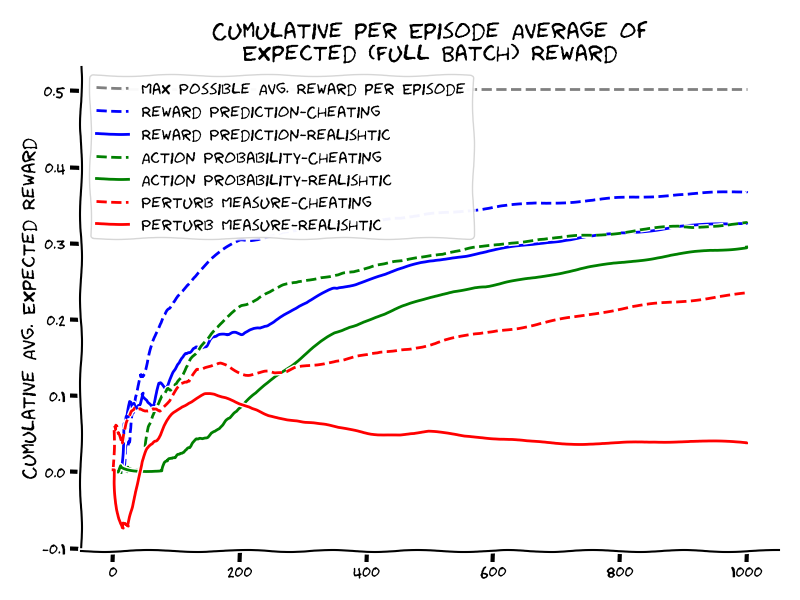

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [22]:
# to_remove solution

def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  """
  Evaluate the parameters, W, of a learning model to determine outputs and
  rewards based on given inputs x and y.
  Parameters:
  - W (ndarray, shape: (1, n_inputs)): Connective strength weights between inputs and the output.
    Represents the connection strengths between neurons and input features.
  - x (ndarray, shape: (n_inputs, batch)): Input features matrix where each column is a separate sample
    from the batch, and each row represents a different input feature.
  - y (ndarray, shape: (1, batch)): Binary labels indicating the presence of prey, used to determine the reward.
  - tau (float, optional): Temperature parameter for the sigmoid function, controlling its steepness.
    A higher tau value leads to a steeper function.
  - rng (np.random.Generator, optional): NumPy random number generator instance for reproducibility.
    If None, a new generator will be created using the default seed.
  Returns:
  - z (ndarray, shape: (1, batch)): Linear combination of weights and inputs.
  - strike_prob (ndarray, shape: (1, batch)): Probability of 'striking', computed using a sigmoid function.
  - strike (ndarray, shape: (1, batch)): Sampled striking outcomes according to strike_prob.
  - r (ndarray, shape: (1, batch)): Actual sampled reward, taking into account the presence of prey, y.
  - r_all (ndarray, shape: (1, batch)): Theoretical reward when striking in all cases.
  - r_exp (ndarray, shape: (1, batch)): Expected reward based on the probability of striking.
  """
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x) # 1 x batch = 1 x n_inputs @ n_inputs x batch
  strike_prob = np_sigmoid(z, tau) # 1 x batch
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-out_spike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           cheat=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.0001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn regardless of whether organism actually strikes or not
    update = (r_all - z) * x
  else: #realishtic
    # learn only from actual recieved rewards
    update = (r-z) * strike * x
  # average the update over all elements in the batch
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y,
                     cheat=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = r_exp * (strike_prob) * (1 -  strike_prob) * x
  else: #realishtic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = r * (strike_prob) * (1 - strike_prob) * x
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.01,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if cheat:
    # evaluate perturbation using expected reward, avg over the mini-batch
    directional_grad_est = (np.mean(r_exp_perturb - r_exp)) / perturbation_scale
  else: #realishtic
    # evaluate perturbation using sampled rewards, avg over the mini-batch
    directional_grad_est = (np.mean(r_perturb - r)) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

################################################################################
# Exercise Complete, simulations and plotting logic follow
################################################################################
# simulation
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
# cheating simulation
cheat_alg_lrs = {'Reward Prediction': 0.0001,
                 'Action Probability': 0.008,
                 'Perturb Measure': 0.0016}
cheat_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=True, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      cheat_reward_results[alg_name].append(np.mean(r))
      cheat_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break

num_steps = 0
real_alg_lrs = {'Reward Prediction': 0.0001,
                'Action Probability': 0.003,
                'Perturb Measure': 0.0000002}
# realishtic simulation
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
actual_exp_reward_results = {alg_name: [] for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = real_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      actual_reward_results[alg_name].append(np.mean(r))
      actual_exp_reward_results[alg_name].append(np.mean(r_exp_full))
    num_steps += 1
    if num_steps > 1000:
      break
# plotting
with plt.xkcd():
  # Create subplots with a shared x-axis
  #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
  fig, ax1 = plt.subplots(figsize=(8,6))
  theoretical_max = np.sum(y1 == 1) / len(y1)

  # Colors for algorithms
  colors = {'Reward Prediction': 'b', 'Action Probability': 'g', 'Perturb Measure': 'r'}

  # First subplot for expected rewards
  ax1.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval_cheat = np.array(cheat_exp_reward_results[alg_name])
    eval_cheat = np.cumsum(eval_cheat)
    eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
    ax1.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

    eval_real = np.array(actual_exp_reward_results[alg_name])
    eval_real = np.cumsum(eval_real)
    eval_real = eval_real / (np.arange(len(eval_real)) + 1)
    ax1.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}-Realishtic')

  ax1.set_title('Cumulative per Episode Average of\nExpected (Full Batch) Reward')
  ax1.set_ylabel('Cumulative Avg. Expected Reward')
  ax1.legend()
  # Second subplot for actual rewards
  # ax2.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  # for alg_name in alg_names:
  #  eval_cheat = np.array(cheat_reward_results[alg_name])
  #  eval_cheat = np.cumsum(eval_cheat)
  #  eval_cheat = eval_cheat / (np.arange(len(eval_cheat)) + 1)
  #  ax2.plot(eval_cheat, linestyle='--', color=colors[alg_name], label=f'{alg_name}-Cheating')

  #  eval_real = np.array(actual_reward_results[alg_name])
  #  eval_real = np.cumsum(eval_real)
  #  eval_real = eval_real / (np.arange(len(eval_real)) + 1)
  #  ax2.plot(eval_real, linestyle='-', color=colors[alg_name], label=f'{alg_name}-Realishtic')

  #ax2.set_title('Cumulative Average of Actual Reward Per Learning Episode')
  #ax2.set_xlabel('Learning Episodes')
  #ax2.set_ylabel('Cumulative Avg. Actual Reward')
  #ax2.legend()
  plt.tight_layout()
  plt.show()

In [28]:
y1.shape

(5620, 1)

Looking at the plots produced by the coding exercise we can see that Reward-Prediction-Error and Action-Probability-Reinforcement both outperform Perturb-Measure-Step, and that this difference is much greater for the realishtic variants than for the cheating variants




Although all the learning algorithms learn less quickly when not allowed to cheat, Perturb-Measure-Step suffers the most. (Realishtic vs. Cheating vs. is: Reward-Prediction-Error can only learn when it strikes and there is an actual reward recieved (plus or minus one, to contrast with the prediction); Action-Probability-Reinforcement only reinforces the actual action taken by the reward recieved, not all actions by the expected reward; and perturb measure step compares an actual reward recieved under the base evaluation mode, with the actual reward recieved under the perturbation mode, not the expected reward.
). This big slow down for Perturb-Measure-Step is because for this algorithms it is the difference in reward between the perturbation, and the base mode evaluations that drives learning. However, when learning from a single experience, and using actual sampled rewards, very few outcomes actually result in effective learning, as can be seen in the table below:

| Case | Correct<br>Action | Perturb<br>Action | Base<br>Action | Perturb - Base<br>Reward<br>Difference | Learning<br>Happens | P(Strike, Perturb)<br> greater than<br>P(Strike, Base) | Learning is<br>Helpful |
|:-------------:|:-------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|:--------------:|
|1 | Strike    | Strike    | Strike    | 0  | No  | - | | -   |
|2 | Strike    | Strike    | No-Strike | 1  | Yes | Yes | Yes |
|3 | Strike    | Strike    | No-Strike | 1  | Yes | No  | No  |
|4 | Strike    | No-Strike | Strike    | -1 | Yes | Yes | No  |
|5 | Strike    | No-Strike | Strike    | -1 | Yes | No  | Yes |
|6 | Strike    | No-Strike | No-Strike | 0  | No  | -   | -   |
|7 | No-Strike | Strike    | Strike    | 0  | No  | -   | -   |
|8 | No-Strike | Strike    | No-Strike | -1 | Yes | Yes | Yes |
|9 | No-Strike | Strike    | No-Strike | -1 | Yes | No  | No  |
|10| No-Strike | No-Strike | Strike    | 1  | Yes | Yes | No  |
|11| No-Strike | No-Strike | Strike    | 1  | Yes | No  | Yes |
|12| No-Strike | No-Strike | No-Strike | 0  | No  | -   | -   |

This is a bit dense, but what it is saying is that first of all, there are many cases where no learning occurs because both the pertubation and the base mode sample the same action and recieve the same rewards, so there is no reward difference at all to drive learning. Note that for small perturbations the action probabilities of the base and perturbed networks will be very similar, so these no learning cases will be the most commen case by far as perturbation sizes become increasinly small. Then, even in the cases where the perturbation mode and the base mode sample different actions, it is possible that the sampled actions will run counter to the way the perturbation shifts the probability of striking. Case 3 in the table above is an example of this. Under the perturbation the probability of striking is not greater than (but rather less than) the probability of striking with the base parameters, however, despite this, the less likely outcome where the perturb network samples striking, and the base network samples not-striking occurs. Because the sample is not aligned with the underlying shift in probabilities, learning from this difference is counterproductive. Now on average, learning will help shift probabilities towards striking in the right situations. However, it will do so only slowly, as many learning episodes will result in no learning, or counterproductive learning.


# 2.1.4.2 Why Delta Rule is Faster Than Perturb-Measure-Step
Although Perturb-Measure-Step suffered the most from being realishtic, even when learning on the full batch instead of just one example at a time, and using expected rewards, we still see that Perturb-Measure-Step is slow compared to Reward-Prediction-Error and Action-Probability-Reinforcement.

<ipython-input-22-4498e0a6f7e7>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x/tau))


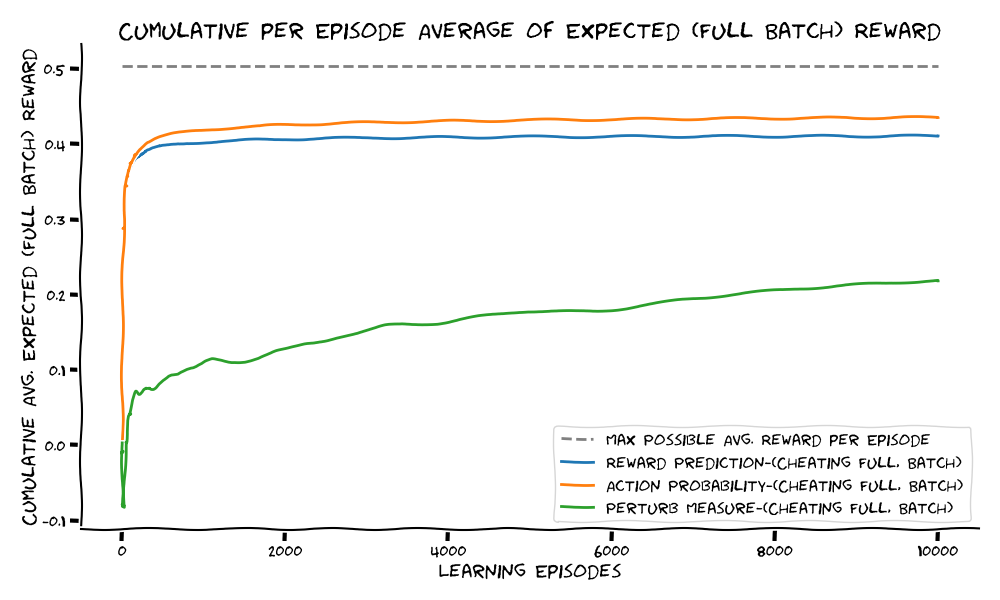

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [27]:
learn_rng = np.random.default_rng(0)
num_epochs = 10000
num_steps = 0
mini_batch_size = Xs_aug.T.shape[0]
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
alg_lrs = {'Reward Prediction': 0.0015,
                 'Action Probability': 0.08,
                 'Perturb Measure': 0.001}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      actual_reward_results[alg_name].append(r)
      exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
  if num_steps > 10000:
    break
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name}-(Cheating Full, Batch)')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

  #fig, ax = plt.subplots(figsize=(10, 6))
  #theoretical_max = np.sum(y1 == 1) / len(y1)
  #ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  #for alg_name in alg_names:
  #  eval = actual_reward_results[alg_name]
  #  eval = np.cumsum(eval)
  #  eval = eval / (np.arange(len(eval)) + 1)
  #  ax.plot(eval, label=f'{alg_name} (Cheating Full Batch)')
  #  ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
  #  ax.set_xlabel('Learning Episodes')
  #  ax.set_ylabel('Cumulative Avg. Actual Reward')
  #  ax.legend()
  #plt.tight_layout()
  #plt.show()

In the previous sequence looking optimization in higher dimensions, analysis showed that the expected improvement from our perturb-measure-step was proportional to the square of the magnitude of the gradient, diveded by $N$ the number of dimensions in the optimization problem, so in our the number of parameters ($65$) to be optimized:

$$
\text{Perturb-Measure-Step Expected Improvement per Step} \propto \frac{\| \mathbf{g} \|^2}{n}$$

And a bit of further analysis found that by thoughtfully scaling the step size to compensate for the low level of alignment of a random test direction with the gradient this could be improved to

$$
\text{Scaled-Perturb-Measure-Step Expected Improvement per Step} \propto \frac{\| \mathbf{g} \|^2}{\sqrt{n}}$$

What this tells us is that with Perturb-Measure-Step learning will always be kind of a zigg-zagging through parameter space, with paramter update steps being almost perpendicular to the direction of maximal improvement (the gradient $\mathbf{g}$)

With this in mind, let's look compute this gradient, $\mathbf{g}$, for our evaluation function, applied to the entire batch of data. Then we can see how the our new update rules (Reward-Prediction-Error and Action-Probability-Reinforcement) relate to the gradient. To do that, we need to translate our evaluation function from python code into math symbols. In code our evaluation function was

In [ ]:
def eval_params(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  z = np.dot(W, x)
  strike_prob = np_sigmoid(z, tau)
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = out_spike_prob * r_all # + (1-out_spike_prob) * 0 # expected reward
  return z, strike_prob, strike, r, r_all, r_exp

We will leave aside the issues of having a stochastic evaluation function for the moment, and just consider the case where we are evaluating performance over the full batch of data, and we are looking at expected reward given the striking probabilities. Then we can write:

$$ \mathbb{E}[R(\mathbf{W}, \mathbf{x}, y)] = \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \Pr(a | \mathbf{x}) \cdot r(a|y)$$

Here $\mathcal{D}$ is the set of all $n$ data points in the full-batch and $\mathcal{A}$ is the set of actions $\{ \text{strike}, \text{no-strike} \}$. Note that $R(\mathbf{W}, \mathbf{x}, y)$ is random variable that depends on which actions the organism (probablistically) selects in which situations, whereas $r(a|y)$ is deterministic (in our example, in the more general case this might also be a random variable, but we are not considering this more general case just yet). The above expression corresponds to the mean of `r_exp` in the code block above, when eval params is applided to the whole batch of data. When writing about the probability of selecting actions we will typically us the notation

$$\pi_{\mathbf{W}}(a|\mathbf{x})$$

to emphasize this is the probability of an action being selected by an organism with policy $\pi$ parameterized by $\mathbf{W}$ given experience $\mathbf{x}$. (In the case where the parameters consist of more than a single weight matrix/vector we typically use $\theta$ to denote all the parameters of the policy function and write $\pi_{\theta}$).

The gradient with respect to $\mathbf{W}$ of this expected reward expression is the *direction* of parameter change that will cause the greatest increase in expected reward for a small change in $\mathbf{W}$, scaled by the *rate* of improvement in expected reward given a small change in $\mathbf{W}$ in that direction. (The gradient is a vector, it has direction and magnitude!) Let's compute this gradient.

$$\begin{align} \nabla_{\mathbf{W}} \mathbb{E}[R(\mathbf{W}, \mathbf{x}, y)] &= \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \nabla_{\mathbf{W}} \pi_{\mathbf{W}}(a | \mathbf{x}) \cdot r(a|y) \\
&= \sum_{(\mathbf{x},y)\in \mathcal{D}} \sum_{a\in\mathcal{A}} \frac{1}{n} \cdot \pi_{\mathbf{W}}(a | \mathbf{x}) \cdot r(a|y) \cdot \nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x})) \end{align}$$

Math trick alert! this rearangement of the terms comes from the application of the chain rule to:
$$\frac{\mathrm{d}}{\mathrm{d}x}\log(f(x)) = \frac{f'(x)}{f(x) } \iff \frac{\mathrm{d}}{\mathrm{d}x} f(x) = \frac{\mathrm{d}}{\mathrm{d}x}\log(f(x)) \cdot f(x)$$

There is a really good reason for organizing the gradient of the expected reward like this, since this now correspondes with how the organisms experiences the environment given it's current policy as determined by parameters $\mathbf{W}$. Specifically, the organism encounters a data point $(\mathbf{x}, y)$ from the data set, each point being equally likely to be encountered, so it encounters this particular point with probability $\frac{1}{n}$. Then, in response to the experience of $\mathbf{x}$ the *policy* of the organism as parameterized by $\mathbf{W}$ selects or samples an action according to

$$\begin{align}
\pi_{\mathbf{W}}(\text{strike} | \mathbf{x}) &= \sigma(\mathbf{Wx}) \\
\pi_{\mathbf{W}}(\text{no-strike} | \mathbf{x}) &= 1 - \sigma(\mathbf{Wx})
\end{align}$$

Once the organism has selected an action, the response/state of the environment determines the reward that the organism experiences according $r(a|y)$. So
the terms in the double sum over all possible experiences and responses, correspond to the probability of that particular experience occuring, $\frac{1}{n}$, the probability that a particular action is selected in response to that particular experience $\pi_{\mathbf{W}}(a | \mathbf{x})$ given the current policy, the reward that results from taking that particular action in that particular situation $r(a|y)$, and lastly this gradient term $\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x}))$

What this tells us, is that if the organism were to just go about it's life experiencing $\mathbf{x}$'s, selecting actions according to its policy, experiencing rewards, and then in response to these experiences shifting the parameters of its policy in the direction of $\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(a|\mathbf{x}))$ scaled by the reward experienced, it would actually be implementing an approximation gradient ascent on the expected reward. Which is perfect, because expected reward is ***exactly*** the quantity the organism should be trying to optimize (presuming that evolultion has linked aligned the intrinsic rewards experienced by the organism with reproductive success).

Okay so let's dig into this gradient term for our particular policy. Let's look at the case when $a = \text{strike}$ first, expanding using our definitions and the chain rule for derivatives

$$ \begin{align}
\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(\text{strike}|\mathbf{x})) &= \nabla_{\mathbf{W}} \log(\sigma(\mathbf{Wx})) \\
&= \frac{1}{\sigma(\mathbf{Wx})} \cdot  \nabla_{\mathbf{W}} \sigma(\mathbf{Wx}) \\
&= \frac{1}{\sigma(\mathbf{Wx})} \cdot \sigma(\mathbf{Wx}) \cdot (1-\sigma(\mathbf{Wx})) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \\
&= (1-\sigma(\mathbf{Wx})) \cdot \mathbf{x}
\end{align}$$

Similarly for $a = \text{no-strike}$ we have

$$ \begin{align}
\nabla_{\mathbf{W}} \log(\pi_{\mathbf{W}}(\text{no-strike}|\mathbf{x})) &= \nabla_{\mathbf{W}} \log(1 - \sigma(\mathbf{Wx})) \\
&= \frac{1}{1 - \sigma(\mathbf{Wx})} \cdot  \nabla_{\mathbf{W}} (1 - \sigma(\mathbf{Wx})) \\
&= \frac{1}{1 - \sigma(\mathbf{Wx})} \cdot -\sigma(\mathbf{Wx}) \cdot (1-\sigma(\mathbf{Wx})) \cdot \nabla_{\mathbf{W}} \mathbf{Wx} \\
&= -\sigma(\mathbf{Wx}) \cdot \mathbf{x}
\end{align}$$


So if we wanted have an update rule based on following the gradient of the expected reward it would look like this

## Expected Reward Gradient Update Rule

$$\Delta W_i = s \cdot (1-\sigma(z)) \cdot r \cdot x_i $$

Or in vector form

$$ \Delta \mathbf{W} = s \cdot (1-\sigma(z)) \cdot r \cdot \mathbf{x}$$

Now, let's compare this ideal update to our two outher update rules

$$\begin{align}
\Delta \mathbf{W} (\text{Reward Prediction}) &= s \cdot (r-z) \cdot \mathbf{x} \\
\Delta \mathbf{W} (\text{Action Probability}) &= s \cdot r \cdot \sigma(z) \cdot (1 - \sigma(z)) \mathbf{x} \\
\Delta \mathbf{W} (\text{Expected Reward Gradient}) &= s \cdot r \cdot (1 - \sigma(z)) \mathbf{x}
\end{align}$$

What each of these have in common is that they all shift the parameters in the direction defined by $\mathbf{x}$ scaled by the reward $r$, modulo some scaling and/or shifting. Reward-Prediction-Error scales the magnitude of the learning step by using ($r-z$) instead of raw $r$ to drive learning (and disregards anything to do with probability as that is under control of the $\tau$ parameter). Action-Probability-Reinforcement scale by probabilities of striking and not-striking, so that updates smaller when the probability of taking the action is either very high (close to one) or very low (close to zero) and is largest when the probability of taking versus not taking the action is smallest. In slight contrast, the Expected-Reward-Gradient episodic update is only scaled by the probability of not taking the action, so the more likely the action is the more strongly it is reinforced. In all cases though, each rule prescribes a parameter change in the ***same direction***. These rules only differ in the way the parameter update is scaled.

This different scaling or weighting of the episodic update rules means that on average when applied over many iterations they will not shift the parameters in the same direction, and as a result will lead to slightly different long term learning outcomes.

To get a sense of this we look at the divergence angle between these updates, when applied over mini-batches of size 1 (perfect alignment) size 10 and size 20.

In [ ]:
def action_log_prob_step(W, x, y,
                         cheat=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  z, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = r_exp * (1 -  strike_prob) * x
  else: #realishtic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = r * (1 - strike_prob) * x
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

In [ ]:
# @markdown **Run this cell** to see a comparison of the gradient of the different algorithms - Reward Prediction, Action Probability and Action Log Probability.
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Action Log Probability']
alg_funcs = [reward_prediction_step, action_prob_step, action_log_prob_step]
alg_lrs = {'Reward Prediction': 0.0001,
           'Action Probability': 0.003,
           'Action Log Probability': 0.001}
actual_reward_results = {alg_name: [] for alg_name in alg_names}
exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      actual_reward_results[alg_name].append(r)
      exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
    if num_steps > 1000:
      break
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name}-(Cheating Less)')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = actual_reward_results[alg_name]
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name} (Cheating Less)')
    ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Actual Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

Looking at the comparative performance of these three different update rules, we see that they all have relatively similar performance in terms of speed of learning. This stems from the fact that they all are leveraging knowledge of how the behaviour is produced by the network to inform. This manifests in the term $\mathbf{x}$ in each of these update rules, since this determines the causal impact a change in the weight parameters $\mathbf{W}$ will have on downstream probabilities of the selected action being taken or not. This should be contrasted with perturb-measure-step which makes no use of such knowledge. Perturb-measure-step assumes total ignorance of the structure of the evaluation function, both the behaviour generating aspect of parameter evaluation, and the reward response aspect of the evaluation function. Perturb-measure-step is using up a lot of its data on implicit inferences of the behaviour generating structure, whereas these other update rules, take the structure of the behaviour generating function as given, which allows them to spen all of their data-buck-bits on improving behaviour, with wasting any on implicit inference of the things it already knows. This is very abstract. To put it in more concrete terms suppose that on a particular episode $x_0$ has a value of zero. Because this will have had no causal impact on the action selected in that episode none of the gradient aligned update rules will make an update to $w_0$. In contrast, perturb-measure-step may well update to $w_0$, so long as the perturbed evaluation is different from the baseline evaluation. This is because, based on a single learning episode, perturb-measure-step can only make a rough guess based on correlations as to the causal impact of any one parameter on the outcome.  So on the one hand an algorithm like perturb-measure-step is very appealing because it implements a kind of optimization with no knowledge of the structure of the network that generates the behaviour or the environmental dynamics that then provide a reward. However, this comes at the high cost taking many learning trials to discover good parameters. Algorithms like perturb measure step are likely implemented and useful for configuring many small and simple neural circuits. However, as networks become large, perturb-measure-step becomes biologically implausible, not because of the mechansims of its physiological implementation, but because it is not effective enought to explain rapidly aquired behavioural plasticity driven by synaptic plasticity in animals. More complicated adaptivity process, the somehow leverage structural knowledge of how behaviour is generated to accelerate learning, are more difficult to imagine mechansims of physilogical implementation for, but are among the simplest algorithms available that can account for the speed and efficacy of adaptive neural plasticity that is observed. Biological plausibility is constrained on two ends, from below, by the plausibility of the electro-physiological mechanisms of neural plasticity, but also, and just as importantly, above by the plausibility of the efficacy of the learning rule. A physiologically simple mechanism that predicts learning on the time course of millions of learning episodes, when behaviourally we see learning over a time course of dozens of episodes, is still biologically implausible. (The brain is likely stacking learning rules, with very simple organisms having many different adaptive processes layered atop eachother,).

___________________________
## Loss Box: Expected-Reward-Gradient **is** Action-Log-Probability-Reinforcement

$$\begin{align} \nabla_{\mathbf{\theta}} \mathbb{E}[R(\mathbf{\theta}, \mathbf{x}, y)] &= \sum_{(\mathbf{x},y)\in \mathcal{D}} \frac{1}{n} \sum_{a\in\mathcal{A}} \nabla_{\mathbf{\theta}} \pi_{\mathbf{\theta}}(a | \mathbf{x}) \cdot r(a|y) \\
&= \sum_{(\mathbf{x},y)\in \mathcal{D}} \sum_{a\in\mathcal{A}} \frac{1}{n} \cdot \pi_{\mathbf{\theta}}(a | \mathbf{x}) \cdot r(a|y) \cdot \nabla_{\mathbf{\theta}} \log(\pi_{\mathbf{\theta}}(a|\mathbf{x})) \end{align}$$

Here $\mathcal{D}$ is the set of all $n$ data points in the full-batch and $\mathcal{A}$ is the set of actions available to the policy. Note that $R(\mathbf{\theta}, \mathbf{x}, y)$ is random variable that depends on which actions the organism (probablistically) selects in which situations, whereas $r(a|y)$ is deterministic in this case. This formulation is a beautiful thing. It tells us that an organism can maximize their expected reward, simply by doing what they do, experiencing their rewards and then shifting the parameters of their policy in the direction of the gradient of the log probability of the action just taken, scaled by the resultant reward. How this derivative is computed and applied physiologically is a rich topic which we address in part later.

Putting this in terms of an episodic or single experience update rule for the parameters we have

$$\Delta \theta = s \cdot r(a|y) \cdot \nabla_{\theta} \log(\pi_\theta(a|\mathbf{x})$$
________________

In [ ]:
learn_rng = np.random.default_rng(0)
num_epochs = 1000
num_steps = 0
mini_batch_size = Xs_aug.T.shape[0]
cooling_rate = 0.04
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
cheat_alg_lrs = {'Reward Prediction': 0.0015,
                 'Action Probability': 0.08,
                 'Perturb Measure': 0.0008}
cheat_actual_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      if alg_name == 'Reward Prediction':
        tau = 1/((num_steps+10.0) * cooling_rate)
      else:
        tau = 1.0
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      cheat_actual_reward_results[alg_name].append(r)
      cheat_exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
    if num_steps > 1000:
      break
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = np.array(cheat_exp_reward_results[alg_name])
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name}-(Cheating Full, Batch)')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    eval = cheat_actual_reward_results[alg_name]
    eval = np.cumsum(eval)
    eval = eval / (np.arange(len(eval)) + 1)
    ax.plot(eval, label=f'{alg_name} (Cheating Full Batch)')
    ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Actual Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
def eval_params(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  a = np.dot(W, x)
  strike_prob = np_sigmoid(a, tau)
  strike = np.array(rng.random(size=strike_prob.shape) < strike_prob, int) # 1->did, 0->didn't
  r = np.where(y == 1, strike, -strike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  r_exp = strike_prob * r_all # + (1-out_spike_prob) * 0 # expected reward
  return a, strike_prob, strike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           cheat=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.0001):
  a, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn regardless of whether organism actually strikes or not
    update = (r_all - a) * x
  else: #realishtic
    # learn only from actual recieved rewards
    update = (r-a) * strike * x
  # average the update over all elements in the batch
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y, r_hat=0,
                     cheat=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  a, strike_prob, strike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if cheat:
    # learn using expected reward
    update = (r_exp - r_hat) * (strike_prob) * (1 -  strike_prob) * x
  else: #realishtic
    # learn only from actual recieved rewards
    # reward of zero recieved when not striking
    update = (r-r_hat) * (strike_prob) * (1 - strike_prob) * x
  update = np.mean(update, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

In [ ]:
learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
#cooling_rate = 0.00001
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
cheat_alg_lrs = {'Reward Prediction': 0.0001,
                 'Action Probability': 0.003,
                 'Perturb Measure': 0.0000001}
cheat_actual_reward_results = {alg_name: [] for alg_name in alg_names}
cheat_exp_reward_results = {alg_name: [] for alg_name in alg_names}
W_s = {alg_name: W_init.copy() for alg_name in alg_names}
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr = cheat_alg_lrs[alg_name]
      W = W_s[alg_name]
      #if alg_name == 'Reward Prediction':
      #  tau = 1/((num_steps+10.0) * cooling_rate)
      #else:
      #  tau = 1.0
      #if alg_name == 'Perturb Measure':
      #  new_W, r, r_exp = alg_func(W, batch_x, batch_y, tau=tau, perturbation_scale=0.01, cheat=False, rng=learn_rng, learning_rate=lr)
      #else:
      new_W, r, r_exp = alg_func(W, batch_x, batch_y, cheat=False, rng=learn_rng, learning_rate=lr)
      _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
      W_s[alg_name] = new_W
      r = np.mean(r)
      r_exp_full = np.mean(r_exp_full)
      cheat_actual_reward_results[alg_name].append(r)
      cheat_exp_reward_results[alg_name].append(r_exp_full)
    num_steps += 1
with plt.xkcd():
  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    exp_r = np.array(cheat_exp_reward_results[alg_name])
    cum_exp_r = np.cumsum(exp_r)
    avg_exp_r = cum_exp_r / (np.arange(len(exp_r)) + 1)
    ax.plot(avg_exp_r, label=f'{alg_name}-(Less Cheating)')
    ax.set_title(f'Cumulative per Episode Average of Expected (Full Batch) Reward')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Expected (Full Batch) Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

  fig, ax = plt.subplots(figsize=(10, 6))
  theoretical_max = np.sum(y1 == 1) / len(y1)
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for alg_name in alg_names:
    r = cheat_actual_reward_results[alg_name]
    cum_r = np.cumsum(r)
    avg_r = cum_r / (np.arange(len(r)) + 1)
    ax.plot(avg_r, label=f'{alg_name}-(Less Cheating)')
    ax.set_title(f'Cumulative Average of Actual Reward Per Learning Episode')
    ax.set_xlabel('Learning Episodes')
    ax.set_ylabel('Cumulative Avg. Actual Reward')
    ax.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
cheat_exp_cum_avg_r

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
theoretical_max = np.sum(y1 == 1) / len(y1)
ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
for alg_name in alg_names:
  smoothed_values = cheat_cum_avg_r[alg_name]
  ax.plot(smoothed_values, label=f'{alg_name}')
  ax.set_title(f'Cumulative Reward')
  ax.set_xlabel('Steps')
  ax.set_ylabel('Cumulative Avg. Reward per Episode')
  ax.legend()

# Ensure the layout is clean and no subplot titles or axes are overlapping
plt.tight_layout()
plt.show()

In [ ]:
# to_remove solution

def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  a = np.dot(W, x)
  out_spike_prob = np_sigmoid(a, tau)
  out_spike = np.array(rng.random(size=out_spike_prob.shape) < out_spike_prob, int)
  r = np.where(y == 1, out_spike, -out_spike) # sampled reward
  r_all = 2*y-1 # reward when striking in all cases
  #expected reward
  r_exp = out_spike_prob * r_all # + (1-out_spike_prob) * 0
  return a, out_spike_prob, out_spike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           reinforce_exp=False,
                           tau=1.0,
                           rng=None,
                           learning_rate=0.001):
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if reinforce_exp:
    update = np.mean((r_all-a) * x, axis=1, keepdims=True).T
  else:
    update = np.mean((r-a) * out_spike * x, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y, r_hat=0,
                     reinforce_exp=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if reinforce_exp:
    update = np.mean((r_exp-r_hat) * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
  else:
    update = np.mean((r-r_hat) * out_spike * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.0001,
                         reinforce_exp=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if reinforce_exp:
    directional_grad_est = (r_exp_perturb - r_exp) / perturbation_scale
  else:
    directional_grad_est = (r_perturb - r) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

learn_rng = np.random.default_rng(0)
num_epochs = 1
num_steps = 0
mini_batch_size = 1
W_init = np.zeros((1,65))
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
alg_names = ['Reward Prediction', 'Action Probability', 'Perturb Measure']
alg_funcs = [reward_prediction_step, action_prob_step, perturb_measure_step]
lr_ranges = {'Reward Prediction': [0.0002, 0.0001, 0.000005],
             'Action Probability': [0.02, 0.008, 0.002],
             'Perturb Measure': [0.017, 0.016, 0.015]}
reward_results = {alg_name: {lr: [] for lr in lr_ranges[alg_name]} for alg_name in alg_names}
smoothed_results = {alg_name: {lr: [] for lr in lr_ranges[alg_name]} for alg_name in alg_names}
W_s = {alg_name: {lr: W_init for lr in lr_ranges[alg_name]} for alg_name in alg_names}
#alpha = 0.05
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  tau = 1/(epoch+1)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    for alg_name, alg_func in zip(alg_names, alg_funcs):
      lr_range = lr_ranges[alg_name]
      for lr_idx, lr in enumerate(lr_range):
        W = W_s[alg_name][lr]
        new_W, r, r_exp = alg_func(W, batch_x, batch_y, reinforce_exp=True, rng=learn_rng, learning_rate=lr)
        _, _, _, _, _, r_exp_full = eval_params(W, Xs_aug.T, y1.T, tau=0.00001, rng=learn_rng)
        W_s[alg_name][lr] = new_W
        reward_results[alg_name][lr].append(np.mean(r_exp_full))
        smoothed_results[alg_name][lr].append(np.mean(reward_results[alg_name][lr]))
    num_steps += 1
n_algorithms = len(alg_names)
cmap = plt.cm.viridis
fig, axes = plt.subplots(n_algorithms, 1, figsize=(10, 6 * n_algorithms), sharex=True)
theoretical_max = np.sum(y1 == 1) / len(y1)
for i, alg_name in enumerate(alg_names):
  ax = axes[i] if n_algorithms > 1 else axes
  learning_rates = np.array(lr_ranges[alg_name])
  norm = plt.Normalize(learning_rates.min(), learning_rates.max())
  ax.hlines(theoretical_max, 0, num_steps, linestyle='--', color='gray', label='Max Possible Avg. Reward per Episode')
  for lr in learning_rates:
    smoothed_values = smoothed_results[alg_name][lr]
    ax.plot(smoothed_values, label=f'LR={lr}', color=cmap(norm(lr)))
    # Set the title, labels and legend
  ax.set_title(f'{alg_name}')
  ax.set_xlabel('Steps')
  ax.set_ylabel('Cumulative Expected Reward per Episode')
  ax.legend()

# Ensure the layout is clean and no subplot titles or axes are overlapping
plt.tight_layout()
plt.show()

So as a caveat, direct comparison of learning algorithms is difficult. Maybe different meta-parmeters (learning rates, tua values) would make one algorithm come out better than the other. Here where we are focused on aquiring pretty good behaviour as quickly as possible (as contrasted with obtaining as good as possible final performance, with-in a feasible

In [ ]:
np.sum(y1 == 0)

In [ ]:
np.sum(y1 == 1)

In [ ]:
np.sum(y1 == 1) / len(y1)

In [ ]:
W_ap

In [ ]:
def np_sigmoid(x, tau=1):
  # high tau more exploration, low tau very little exploration
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

def eval_params(W, x, y, tau=1, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  a = np.dot(W, x)
  out_spike_prob = np_sigmoid(a, tau)
  out_spike = np.array(rng.random(size=out_spike_prob.shape) < out_spike_prob, int)
  r = np.where(y == 1, out_spike, -out_spike)
  r_all = 2*y-1
  r_exp = out_spike_prob * r_all
  return a, out_spike_prob, out_spike, r, r_all, r_exp

def reward_prediction_step(W, x, y,
                           reinforce_exp=False,
                           tau=1,
                           rng=None,
                           learning_rate=0.001):
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if reinforce_exp:
    update = np.mean((r_all-a) * x, axis=1, keepdims=True).T
  else:
    update = np.mean((r-a) * out_spike * x, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def action_prob_step(W, x, y, r_hat=0,
                     reinforce_exp=False,
                     tau=1,
                     rng=None,
                     learning_rate=0.001):
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  if reinforce_exp:
    update = np.mean((r_exp-r_hat) * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
  else:
    update = np.mean((r-r_hat) * out_spike * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
  W_new = W + update * learning_rate
  return W_new, r, r_exp

def perturb_measure_step(W, x, y,
                         perturbation_scale=0.001,
                         reinforce_exp=False,
                         tau=1,
                         rng=None,
                         learning_rate=0.001):
  if rng is None:
    rng = np.random.default_rng()
  a, out_spike_prob, out_spike, r, r_all, r_exp = eval_params(W, x, y, tau, rng)
  raw_test_perturb = learn_rng.standard_normal(size=(W.shape))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  perturbed_W = W + test_perturbation
  _, _, _, r_perturb, r_all_perturb, r_exp_perturb = eval_params(perturbed_W, x, y, tau, rng)
  if reinforce_exp:
    directional_grad_est = (r_exp_perturb - r_exp) / perturbation_scale
  else:
    directional_grad_est = (r_perturb - r) / perturbation_scale
  update = learning_rate * directional_grad_est * unit_test_perturb
  W_new = W + update
  return W_new, r, r_exp

learn_rng = np.random.default_rng(0)
num_epochs = 2
lr_rp = 0.001
lr_ap = 0.005
lr_pm = 0.005
perturbation_scale = 0.0001
mini_batch_size = 1
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W_rp = W_init
W_ap = W_init
W_pm = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
num_steps = 0
rewards_rp = []
rewards_ap = []
rewards_pm = []
smoothed_rp = []
smoothed_ap = []
smoothed_pm = []
alpha = 0.001
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  tau = 1/(epoch+1)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    W_rp, r_rp, r_rp_exp = reward_prediction_step(W_rp, batch_x, batch_y, reinforce_exp=True, tau=tau, rng=learn_rng, learning_rate=lr_rp)
    W_ap, r_ap, r_ap_exp = action_prob_step(W_ap, batch_x, batch_y, reinforce_exp=True, tau=tau, rng=learn_rng, learning_rate=lr_ap)
    W_pm, r_pm, r_pm_exp = perturb_measure_step(W_pm, batch_x, batch_y, reinforce_exp=True, tau=1, rng=learn_rng, learning_rate=lr_pm)
    num_steps += 1
    rewards_rp.append(np.mean(r_rp))
    rewards_ap.append(np.mean(r_ap))
    rewards_pm.append(np.mean(r_pm))

    if len(smoothed_rp) == 0:
      smoothed_rp.append(rewards_rp[-1])
      smoothed_ap.append(rewards_ap[-1])
      smoothed_pm.append(rewards_pm[-1])
    else:
      smoothed_rp.append(alpha * rewards_rp[-1] + (1 - alpha) * smoothed_rp[-1])
      smoothed_ap.append(alpha * rewards_ap[-1] + (1 - alpha) * smoothed_ap[-1])
      smoothed_pm.append(alpha * rewards_pm[-1] + (1 - alpha) * smoothed_pm[-1])

fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes.
ax.plot(smoothed_rp, label='Reward Prediction', color='blue', alpha=0.5)
ax.plot(smoothed_ap, label='Action Probability', color='red', alpha=0.5)
ax.plot(smoothed_pm, label='Perturb Measure', color='green', alpha=0.5)

ax.set_title('(Smoothed) Average Rewards')  # Title of the plot
ax.set_xlabel('Steps')  # Label for the x-axis
ax.set_ylabel('Average Reward')  # Label for the y-axis
ax.legend()  # Add a legend

plt.show()  # Display the plot

In [ ]:
learn_rng = np.random.default_rng(0)

In [ ]:
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
print(Xs_aug.shape)
print(Xs_aug[:1])

In [ ]:
W = 0.2 * (learn_rng.random(size=(1,65)) - 0.5)
print(W)
x = Xs_aug[:5].T
print(x)

In [ ]:
a = np.dot(W, x)
print(a)
out_spike_prob = np_sigmoid(a)
print(out_spike_prob)

In [ ]:
out_spikes = np.array(learn_rng.random(size=out_spike_prob.shape) < out_spike_prob, int)
print(out_spikes)

In [ ]:
y = y1[:5].T
print(y)

In [ ]:
 R = np.where(y == 1, out_spikes, -out_spikes)
 print(R)

In [ ]:
all_R = np.where(y == 1, 1, -1)
print(all_R)

In [ ]:
mae = np.mean(np.abs(all_R - a))
print(mae)

In [ ]:
print(a)

In [ ]:
y-a

In [ ]:
all_R - a

In [ ]:
print(R)

In [ ]:
def forward_backward_pass(W, x, y, tau=1, rng=None, learning_rate=0.001, verbose=False):
  if rng is None:
    rng = np.random.default_rng()
  a = np.dot(W, x)
  out_spike_prob = np_sigmoid(a, tau)
  out_spikes = np.array(learn_rng.random(size=out_spike_prob.shape) < out_spike_prob, int)
  all_R = np.where(y == 1, 1, -1)
  mae = np.mean(np.abs(all_R - a))
  if verbose:
    R = np.zeros(out_spikes.shape) # 1 x batch
    did_strike = out_spikes == 1
    did_not_strike = out_spikes == 0
    should_strike = y == 1
    should_not_strike = y == 0
    TP = np.logical_and(did_strike, should_strike) # True Positive
    FP = np.logical_and(did_strike, should_not_strike) # False Positive
    FN = np.logical_and(did_not_strike, should_strike) # False Negative
    TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
    R[TP] = 1
    R[FP] = -1
    R[FN] = 0
    R[TN] = 0
    TPs = np.sum(TP)
    FPs = np.sum(FP)
    FNs = np.sum(FN)
    TNs = np.sum(TN)
    confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    print(f'Mean Absolute Error: {mae}')
    return None
  else:
    R = np.where(y == 1, out_spikes, -out_spikes)
    # only learn from strikes taken
    update = np.mean((R-a) * out_spikes * x, axis=1, keepdims=True).T
    # always learn
    #update = np.mean((all_R-a) * x, axis=1, keepdims=True).T
    W_new = W + update * learning_rate
    return W_new, a, out_spikes, R, mae

forward_backward_pass(W, x, y, tau=1, rng=learn_rng, learning_rate=0.00001)

In [ ]:
forward_backward_pass(W, x, y, tau=1, rng=learn_rng, learning_rate=0.00001)

In [ ]:
learn_rng = np.random.default_rng(0)
num_epochs = 200
learning_rate = 0.0001
mini_batch_size = 1
W_init = 0.2 * (learn_rng.random(size=(1,65)) - 0.5)
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
forward_backward_pass(W, batch_x, batch_y, tau=0.0001, rng=learn_rng, learning_rate=learning_rate, verbose=True)
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  tau = 1/(epoch+1)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    W, _, _, _, _ = forward_backward_pass(W, batch_x, batch_y, tau=tau, rng=learn_rng, learning_rate=learning_rate, verbose=False)
  if epoch % 10 == 0:
    elapsed_time = time.time() - start_time
    batch_x = Xs_aug.T
    batch_y = y1.T
    _, _, _, batch_R, batch_mae = forward_backward_pass(W, batch_x, batch_y, tau=0.0001, rng=learn_rng, learning_rate=learning_rate, verbose=False)
    print(f'Epoch {epoch} | Reward Sample: {np.sum(batch_R)} | Strike Reward MAE: {batch_mae} | Time elapsed: {elapsed_time:.2f} seconds')
forward_backward_pass(W, Xs_aug.T, y1.T, tau=0.0001, rng=learn_rng, verbose=True)

This seems to get in the neighbourhood of 2300, so not as good as perturb measure step. But why? Because here we are minimizing a prediction error, which is only closely correleated with correctly choosing the right action as often as possible. So while this prediction mis-match could be a nice way for learning to occur, if we really want to maximize reward, we need to make sure that reward is what we are most directly maximizing. To do this we need to change our update rule so that we directly increase the probability of striking when a strike happens and it is rewarded, and decrease the probability of striking when it happens and a negative reward results.

## Action Probability Reinforcement

$$ \Delta W_i = s r \sigma'(a) x_i$$

or in vector form

$$ \Delta \mathbf{W} = s r \sigma'(a) \mathbf{x}$$

The goal here is to more directly associate action with reward, as contrasted with doing this inderectly by tying action probabilities to a reward prediction.

In [ ]:
def forward_backward_pass(W, x, y, tau=1, rng=None, learning_rate=0.001, verbose=False):
  if rng is None:
    rng = np.random.default_rng()
  a = np.dot(W, x)
  out_spike_prob = np_sigmoid(a, tau)
  out_spikes = np.array(learn_rng.random(size=out_spike_prob.shape) < out_spike_prob, int)
  all_R = np.where(y == 1, 1, -1)
  if verbose:
    R = np.zeros(out_spikes.shape) # 1 x batch
    did_strike = out_spikes == 1
    did_not_strike = out_spikes == 0
    should_strike = y == 1
    should_not_strike = y == 0
    TP = np.logical_and(did_strike, should_strike) # True Positive
    FP = np.logical_and(did_strike, should_not_strike) # False Positive
    FN = np.logical_and(did_not_strike, should_strike) # False Negative
    TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
    R[TP] = 1
    R[FP] = -1
    R[FN] = 0
    R[TN] = 0
    TPs = np.sum(TP)
    FPs = np.sum(FP)
    FNs = np.sum(FN)
    TNs = np.sum(TN)
    confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    R = np.where(y == 1, out_spikes, -out_spikes)
    # only learn from strikes taken
    # reward probability based updated
    update = np.mean(R * out_spikes * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
    # always learn
    #update = np.mean(all_R * (out_spike_prob) * (1 - out_spike_prob) * x, axis=1, keepdims=True).T
    W_new = W + update * learning_rate
    return W_new, a, out_spikes, R

forward_backward_pass(W, x, y, tau=1, rng=learn_rng, learning_rate=0.00001)

In [ ]:
learn_rng = np.random.default_rng(0)
num_epochs = 200
learning_rate = 0.0002
mini_batch_size = 1
W_init = 0.2 * (learn_rng.random(size=(1,65)) - 0.5)
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_y = y1.T
forward_backward_pass(W, batch_x, batch_y, tau=0.0001, rng=learn_rng, learning_rate=learning_rate, verbose=True)
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  tau = 1/(epoch+1)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    W, _, _, _ = forward_backward_pass(W, batch_x, batch_y, tau=tau, rng=learn_rng, learning_rate=learning_rate, verbose=False)
  if epoch % 20 == 0:
    elapsed_time = time.time() - start_time
    batch_x = Xs_aug.T
    batch_y = y1.T
    _, _, _, batch_R = forward_backward_pass(W, batch_x, batch_y, tau=0.0001, rng=learn_rng, learning_rate=learning_rate, verbose=False)
    print(f'Epoch {epoch} | Reward Sample: {np.sum(batch_R)} | Time elapsed: {elapsed_time:.2f} seconds')
forward_backward_pass(W, Xs_aug.T, y1.T, tau=0.0001, rng=learn_rng, verbose=True)

So this is basically the same as perturb measure step, except that it doesn't require a seperate purturbation mode

In [ ]:
# @markdown Run this cell to see how a simple stochastic spiking network can learn to solve this problem

def np_sigmoid(x, tau=1):
  x_scaled = np.clip(x/tau, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x/tau))

Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def delta_rule_batch(W, x, y, tau, learning_rate, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise, used delta rule
  based on reward perdiction to compute updates
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activation level given input
  a = np.dot(W, x) # 1 x batch
  # strike probability
  out_spike_prob = np_sigmoid(a, tau) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  out_spikes = np.array(rng.random(size=out_spike_prob.shape) < out_spike_prob, int)  # 1 x batch
  R = np.zeros(out_spikes.shape) # 1 x batch
  did_strike = out_spikes == 1
  did_not_strike = out_spikes == 0
  should_strike = y == 1
  should_not_strike = y == 0
  R = np.where(y == 1, out_spikes, -out_spikes)
  updates = learning_rate * (R-a) * out_spikes * x #inuput dim x batch
  mean_squared_reward_prediction_errors = np.mean((y - a)**2)
  if verbose:
    TP = np.logical_and(did_strike, should_strike) # True Positive
    FP = np.logical_and(did_strike, should_not_strike) # False Positive
    FN = np.logical_and(did_not_strike, should_strike) # False Negative
    TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
    R[TP] = 1
    R[FP] = -1
    R[FN] = 0
    R[TN] = 0
    TPs = np.sum(TP)
    FPs = np.sum(FP)
    FNs = np.sum(FN)
    TNs = np.sum(TN)
    confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), updates, mean_squared_reward_prediction_errors

learn_rng = np.random.default_rng(0)
num_epochs = 100
learning_rate = 0.0001
mini_batch_size = 1
W_init = np.zeros((1,65))
tau_init = 5
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  tau = tau_init/(10*epoch+1)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_y = y1[batch_indices].T
    _, W_update, _ = delta_rule_batch(W, batch_x, batch_y, tau, learning_rate, rng=learn_rng)
    W = W + W_update.T
  if epoch % 2 == 0:
    elapsed_time = time.time() - start_time
    batch_x = Xs_aug.T
    batch_y = y1.T
    batch_reward, _, mean_squared_reward_prediction_errors = delta_rule_batch(W, batch_x, batch_y, tau, learning_rate, rng=learn_rng)
    print(f'Epoch {epoch} | Batch Reward: {batch_reward} | Avg. Prediction Error {mean_squared_reward_prediction_errors}|Time elapsed: {elapsed_time:.2f} seconds')
delta_rule_batch(W, Xs_aug.T, y1.T, tau, learning_rate, rng=learn_rng, verbose=True)

In [ ]:
# @markdown Run this cell to see how a simple stochastic spiking network can learn to solve this problem

def np_sigmoid(x):
  x = np.clip(x, -200, 200) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def update_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise, input and output
  neurons are spiking
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # input spike probs
  squash_x = np_sigmoid(x) # inputs x batch
  # activation level given input
  a = np.dot(W, squash_x) # 1 x batch
  # strike probability
  out_spike_prob = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  out_spikes = np.array(rng.random(size=out_spike_prob.shape) < out_spike_prob, int)  # 1 x batch
  R = np.zeros(out_spikes.shape) # 1 x batch
  did_strike = out_spikes == 1
  did_not_strike = out_spikes == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  updates = learning_rate * R * squash_x #inuput dim x batch
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix, updates


  return replicated_x

def compact_update_stochastic_spiking_batch(W, x, y, learning_rate, rng=None):
  """
  Evaluates parameters of a simple behaviour circuit given inputs and target outputs.
  Optimized for performance by focusing solely on update computations.
  Args:
    W: (outputs(1) x inputs(65) np.array)
        weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output
    learning_rate: scalar, the learning rate for updates

  Returns:
    updates: gradient updates for weight adjustments
  """
  if rng is None:
    rng = np.random.default_rng()
  squash_x = np_sigmoid(x)
  a = np.dot(W, x)  # 1 x batch
  out_spike_prob = np_sigmoid(a)  # Logistic sigmoid function
  out_spikes = (rng.random(out_spike_prob.shape) < out_spike_prob).astype(int)
  # Compute rewards
  R = np.where(y == 1, out_spikes, -out_spikes)
  # Compute updates
  updates = learning_rate * R * squash_x
  return updates

learn_rng = np.random.default_rng(0)
num_epochs = 100
learning_rate = 0.0001
mini_batch_size = 1
input_replications = 100
W_init = np.zeros((1,65*input_replications))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_x = np.repeat(batch_x, input_replications, axis=0)
batch_y = y1.T
update_stochastic_spiking_batch(W, batch_x, batch_y, rng=learn_rng, verbose=True)
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_x = np.repeat(batch_x, input_replications, axis=0)
    batch_y = y1[batch_indices].T
    W_update = compact_update_stochastic_spiking_batch(W, batch_x, batch_y, learning_rate, rng=learn_rng)
    W = W + W_update.T
  if epoch % 2 == 0:
    elapsed_time = time.time() - start_time
    batch_x = Xs_aug.T
    batch_x = np.repeat(batch_x, input_replications, axis=0)
    batch_y = y1.T
    batch_reward, confusion_matrix, W_update = update_stochastic_spiking_batch(W, batch_x, batch_y, rng=learn_rng)
    print(f'Epoch {epoch} completed | Batch Reward Sample: {batch_reward}|Time elapsed: {elapsed_time:.2f} seconds')
update_stochastic_spiking_batch(W, Xs_aug.T, y1.T, rng=learn_rng, verbose=True)

In [ ]:
# @markdown Run this cell to see how a simple stochastic spiking network can learn to solve this problem

def np_sigmoid(x):
  x = np.clip(x, -200, 200) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def update_stochastic_spiking_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise, input and output
  neurons are spiking
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # input spike probs
  in_spike_probs = np_sigmoid(x) # inputs x batch
  # sampled spikes
  in_spikes = np.array(rng.random(size=x.shape) < in_spike_probs, int)
  # activation level given input spikes
  a = np.dot(W, in_spikes) # 1 x batch
  # strike probability
  out_spike_prob = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  out_spikes = np.array(rng.random(size=out_spike_prob.shape) < out_spike_prob, int)  # 1 x batch
  R = np.zeros(out_spikes.shape) # 1 x batch
  did_strike = out_spikes == 1
  did_not_strike = out_spikes == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  updates = learning_rate * R * out_spikes * in_spikes #inuput dim x batch
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix, updates


  return replicated_x

def compact_update_stochastic_spiking_batch(W, x, y, learning_rate, rng=None):
  """
  Evaluates parameters of a simple behaviour circuit given inputs and target outputs.
  Optimized for performance by focusing solely on update computations.
  Args:
    W: (outputs(1) x inputs(65) np.array)
        weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output
    learning_rate: scalar, the learning rate for updates

  Returns:
    updates: gradient updates for weight adjustments
  """
  if rng is None:
    rng = np.random.default_rng()
  # Compute input spikes
  in_spike_probs = np_sigmoid(x)  # Logistic sigmoid function
  in_spikes = (rng.random(x.shape) < in_spike_probs).astype(int)
  # Compute output spikes
  a = np.dot(W, in_spikes)  # 1 x batch
  out_spike_prob = np_sigmoid(a)  # Logistic sigmoid function
  out_spikes = (rng.random(out_spike_prob.shape) < out_spike_prob).astype(int)
  # Compute rewards
  R = np.where(y == 1, out_spikes, -out_spikes)
  # Compute updates
  updates = learning_rate * (R * out_spikes) * in_spikes
  return updates

learn_rng = np.random.default_rng(0)
num_epochs = 100
learning_rate = 0.0001
mini_batch_size = 1
input_replications = 100
W_init = np.zeros((1,65*input_replications))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
batch_x = Xs_aug.T
batch_x = np.repeat(batch_x, input_replications, axis=0)
batch_y = y1.T
update_stochastic_spiking_batch(W, batch_x, batch_y, rng=learn_rng, verbose=True)
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_x = Xs_aug[batch_indices].T
    batch_x = np.repeat(batch_x, input_replications, axis=0)
    batch_y = y1[batch_indices].T
    W_update = compact_update_stochastic_spiking_batch(W, batch_x, batch_y, learning_rate, rng=learn_rng)
    W = W + W_update.T
  if epoch % 2 == 0:
    elapsed_time = time.time() - start_time
    batch_x = Xs_aug.T
    batch_x = np.repeat(batch_x, input_replications, axis=0)
    batch_y = y1.T
    batch_reward, confusion_matrix, W_update = update_stochastic_spiking_batch(W, batch_x, batch_y, rng=learn_rng)
    print(f'Epoch {epoch} completed | Batch Reward Sample: {batch_reward}|Time elapsed: {elapsed_time:.2f} seconds')
update_stochastic_spiking_batch(W, Xs_aug.T, y1.T, rng=learn_rng, verbose=True)

In [ ]:
W

In [ ]:
rewards = []
for _ in range(100):
  batch_reward, _, _ = update_stochastic_spiking_batch(W, Xs_aug.T, y1.T, rng=learn_rng)
  rewards.append(batch_reward)

# Convert list to numpy array for better handling in matplotlib
rewards_array = np.array(rewards)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(rewards_array, bins=30, color='blue', alpha=0.7)
plt.show()

In [ ]:
W = np.zeros((1,65))

In [ ]:
update_stochastic_spiking_batch(W, Xs_aug.T, y1.T, rng=learn_rng, verbose=True)

In [ ]:
W

In [ ]:
def stochastic_single_action(W, x, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  pre_spike_probs = np_sigmoid(x)
  input_spikes = np.array(rng.random(size=x.shape) < pre_spike_probs, int)
  # activaation
  output_activation = np.dot(W,pre_spikes)
  # strike probability, does the output spike
  output_spike_prob = np_sigmoid(a)
  sampled_action = rng.random() < y_hat
  return sampled_action, input_spikes

def stochastic_single_reward(a, y):
  if a == 1:
    if y == 1
      R = 1
    elif y == 0:
      R = -1
    else:
      raise ValueError(f'Unknown target: {y}')
  elif a == 0:
    R = 0
  else:
    raise ValueError(f'Unknown action: {a}')
  return R

def stochastic_single_update(W, x, y, rng=None):
  if rng is None:
    rng = np.random.default_rng()
  sampled_action, input_spikes = stochastic_single_action(W, x, rng)
  reward = stochastic_single_reward(sampled_action, y)
  W += learning_rate * sampled_action * input_spikes * reward
  return W


The organism recieves a reward of 1 for striking at the right time and a penalty of -1 for striking at the wrong time.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... set the appropriate rewards for
# for the evaluations function
raise NotImplementedError("Exercise: Set the reward for different outcomes")
################################################################################

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x)
  # strike probability
  y_hat = np_sigmoid(a)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random() < y_hat
  if y_sample == 1: #organism strikes
    if y == 1: #prey is present
      R = ...
    else: # prey is not present
      R = ...
  else: # organism does not strike
    R = ...
  if verbose:
    print(f'Probability of striking: {y_hat}')
    action_string = 'Strike' if y_sample == 1 else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

In [ ]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x)
  # strike probability
  y_hat = np_sigmoid(a)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random() < y_hat
  if y_sample == 1: #organism strikes
    if y == 1: #prey is present
      R = 1
    else: # prey is not present
      R = -1
  else: # organism does not strike
    R = 0
  if verbose:
    print(f'Probability of striking: {y_hat}')
    action_string = 'Strike' if y_sample == 1 else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

So that evaluates the reward over a single experience. We can use numpy broadcasting to apply this same reward calculation efficiently to many, even all, the input-out pairs in our data set. We call this **batch** evaluation.

In [ ]:
################################################################################
# TODO for students: Complete the lines with ... to compute the number of
# True Positives, False Positives, True Negative and False Negatives in the batch
raise NotImplementedError("Exercise: Compute the number of different Outcomes")
################################################################################

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == ...
  did_not_strike = y_sample == ...
  should_strike = y == ...
  should_not_strike = y == ...
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

In [ ]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == 1
  did_not_strike = y_sample == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

Note that the two evaluations give different total rewards, even though the exact same synaptic weights $\mathbf{W}$ are being used, on the exact same batch of inputs $\mathbf{x}$ and prey presence indicators $y$. This is expected given the inherent stochasticity in the organisms behaviour. This stochastic evaluation of the synaptic weights will make things difficult for the perturb-measure-step alogorithm though, because it relies upon precise function evaluations to get good estimates of the rate of improvement in a given direction in parameter space. We can overcome this stochastic evaluation issue though by using our knowledge of how the different probabilities of striking or not determine the expected, or average reward. By directly evaluating expected reward we can recover a precise, deterministic evaluation function.

In [ ]:
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)
print('\nEvaluation 2')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)

Note that as hoped, the evaluation of parameters using expected reward, is consistent, as it should be. As a sanity check we see that the distribution of stochastic evaluations is roughly symmetric, and centered around this expectation, with the average of many such stochastic evaluations becoming close to our calculated expected value.

In [ ]:
# @markdown **Run this cell** to visualize the distribution of stochastic parameter evaluation, relative to the expectation.
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == 1
  did_not_strike = y_sample == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

W_test = np.zeros((1,65))
exp_reward, _ = eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=False)

# Generate stochastic rewards
stochastic_rewards = []
for _ in range(500):  # Simulate 100 times to create a distribution
  r, _ = eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=False)
  stochastic_rewards.append(r)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
remove_ip_clutter(fig)
ax.hist(stochastic_rewards, bins=20, alpha=0.75, label='Stochastic Evaluations')
ax.axvline(x=exp_reward, color='r', linestyle='dashed', linewidth=2, label=f'Expected Reward: {exp_reward}')
ax.set_title('Comparison of Stochastic Evaluations and Expected Reward')
ax.set_xlabel('Reward')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

As yet another sanity check we calculate the expected reward when striking and not striking with equal probability, in all circumstances, which is what we expect from a $\mathbf{W}$ of all zeros.

In [ ]:
# There are this many cases where striking is good
np.sum(y1 == 1)

In [ ]:
# And this many cases where striking is bad
np.sum(y1 == 0)

In [ ]:
# W = 0 should strike half the time no matter what,
# in which case would expect a reward of
(2829 - 2791) / 2

That all checks out, so now that we have some confidence in our evaluation function let's see if perturb-measure-step is able to find a good set of values for $\mathbf{W}$ using the batch expected value version of parameter evaluation. Run the training loop. The process will take a minute or two to complete, while its running inspect the code and see if it makes sense to you.

In [ ]:
# @title Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 60000
step_scale = 0.002
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
for step in range(num_steps):
  R_current, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  raw_test_perturb = learn_rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test, _ = eval_params_expectation_batch(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Expected Total Batch Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

The best possible score is 2829, and perturb measure step is able to discover network parameters that achieve a score of roughly 2500, in 60,000 steps. This is pretty good, better than we the humans were able to do in terms of figuring out the pattern, before we got bored of the problem in a few minutes. This is all well and good as an optimization exercise, but if we want to connect this form of optimization back to our inspirational cartoon of neural behaviour as a kind of learning, there are a few issues. Three major issues stand out as ways in which the perturb-measure-step training loop above deviates from a process that is simple and local enough to serve as plausible (even if very abstract) model of a physiological syanptic plasticity processes. These key issues are:
1. The organism's striking behaviour is stochastic but expected reward outcomes, not actual obtained reward outcomes are used to drive updates to the synaptic parameters $\mathbf{W}$.
2. The evaluation of a given synaptic configuration is based on performance over all of the 5620 of distcint input-outpur pairs (sensory-pattern, prey-presence) in the data set that defines the "environment" of this learning problem. Physiologically viable would be evaluations over a single, or at least relatively few, stimulus-response-reward episodes.
3. Evaluations are performed in seperate perturbation and non-perturbation modes in the training loop above. A single mode of evaluation that operated fully "online" and in congunction with the ongoing generation of behaviour is more simple and easy to imagine physiological implementations of.

There are of course many other ways in which the this cartoon learning system deviates from what might plausibly be implemented in an actual simple neural system, but these have more to do with the abstractness of the model, and can concievibly be remedied with careful choices about how to make the model more concrete so as to map nicely onto measurable phyiological features of neural plasticity. In contrast, for the critical points oulined above, it is difficult to imagine how any of these key issues can be overcome physiologically, without invoking additional complex neural circuits and processes, the orgin of which also need to be explained. So for this sequence and the next we focus on addressing these core issues, different-modes, batch versus single experience based reward, and expected versus actual recieved (stochastic) reward.

In the rest of this sequence we will adapt the base perturb-measure-step update rule to address each of these three issues. But first let's just get a bit of a sense of how these issues impinge upon the fantasy of using perturb-measure-step as an algorithm that might feasibly be used by a living organism to update the connection strengths of this simple network determining behaviour in response to stimulus. In each interation in the vanilla perturb-measure-step training loop implemented above the organism first evaluates its current parameters based on the expected reward over all 5620 possible experiences. It then perturbs its synaptic parameters and evaluates its performance again on all 5620 experiences, these two evaluations are compared to determine $\Delta R$ and this together with the pertrubations $\Delta W_i$ determine the synaptic connections update according to

$$ W_i' = W_i + s \ \Delta W_i \ \Delta R $$
where
$$\Delta R = R(\mathbf{W} + \Delta \mathbf{W}) - R(\mathbf{W})$$
and $R(\mathbf{W})$ is our reward/evaluation function.
Note that $s$ needs to be carefully choosen to account both for the average size of the perturbation $\| \mathbf{W} \|$, the appropriately level of scaling given the expected alignment of a random perturbation with the gradient given the dimensionality of $\mathbf{W}$, and the relative scale of the gradient. While this is can be a challenge in practical applications, the "dialing-in" of meta-parameters of learning algorithms is something that we expect evolution to be quite good at.

This process would require the organism somehow integrate all of the reward outcomes of all 5620 experiences, remember this aggregated outcome, then integrate up the reward outcomes of another 5620 experiences accumulated while in 'perturbation' mode, and then update its parameters based on a comparison of the remembered and the recently accumlated aggregate reward outcome. This all seems a bit complicated, and difficult to implement with simple, primarily local, synaptic plasticity mechanisms. What we would like intead is a version of perturb-measure-step that updates its synaptic weights as a result of every reward experience, doesn't rely on an expected reward calculation, and that does not have a seperate perturbation mode.

Removing the seperate perturbation mode is perhaps the easiest issue to address so we take this on first.

# 2.1.4.2 Stochastic-Step-Measure-Step

One simple way to avoid a seperate perturbation evaluation is to simply compress the perturbation and the update into a single step. We call such an update method step-measure-step as contrasted with perturb measure step. This new update rule looks like this.



$$\ W_{i}(t+1)= W_i(t) + s \ (W_i(t) - W_i(t-1)) \ \ R(\mathbf{W}(t)) - R(\mathbf{W}(t-1)) + \xi_{i}(t)$$

Previously we used $\Delta$ to denote the perturbation and did not directly reference the parameter update. Because now we are combining the perturbation and the parameter update we use $\Delta$ to denote this combined change, that is
$$ \ W_{i}(t+1) - W_i(t) = \Delta W_i(t) $$

Then the above simplifies

$$ \Delta W_i(t) = s \ \Delta W_i(t-1) \ \Delta R(t) + \xi_i(t) $$
Here $\Delta R(t) = R(\mathbf{W}(t)) - R(\mathbf{W}(t-1))$

Let's see if


In [ ]:
# @title Stochastic-Step-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 100000
init_step_scale = 0.003 * np.sqrt(65)
init_noise_scale = 0.0005
total_scale = 1.0
#later_step_scale = 0.002 * np.sqrt(65)
#later_noise_scale = 0.0001
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
step_scale = init_step_scale
noise_scale = init_noise_scale
for step in range(num_steps):
  R_old = R
  R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  delta_R = R - R_old
  delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
  delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
  W += delta_W

  if step == 0 or (step + 1) % 10000 == 0:
    elapsed_time = time.time() - start_time
    #print(f'Delta R: {delta_R}')
    #print(f'Delta W: {delta_W}')
    print(f'Step {step + 1}/{num_steps} completed | Total Expected Reward: {R:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
    #if step > 40000:
    #  step_scale = later_step_scale
    #  noise_scale = later_noise_scale
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

So this trick of smushing the perturbation and the update into a single step seems to work okay, though not as well as doing the very careful perturbation, but it shows that much of the correct pattern response to stimulus can be discovered through this mode. This particular idea for smushing together the perturbation and the update was is known as ALOPEX (an acronym from "ALgorithms Of Pattern EXtraction",  first proposed by Tzanakou and Harth in 1974.) This is one way of not having a seperate perturbation and non-perturbation mode. There are other ways, such as leveraging the stochasticity of relative spike timings (ref seung), and using reward signals directly (or above some anticipated baseline) and we will discuss these later. For now, it is enough to know that this issue can be mitigated, though with some apparrent cost to overall performance (relative to perturb-measure-step). Let's move on to the next issue.

# 2.1.4.3 Full-Batch versus Mini-Batch Perturb-Measure-Step

Another issue in terms of physiological viability was parameter evaluation based on performance across all possible experiences. In a simple model of learning and synaptic plasticity, we would like learning to be driven by the outcomes of a single stimulus-response-reward experience.

This relates to an important idea in machine learning. The idea of the mini-batch. Even though we are ulitmately interested is the performance of the parameters over all of the input-target pairs in the data set, given how computers operate, it is typically possible to generate a sample evaluation based on a small random sample of the input-target pairs in the data set. Such a samlpe is called a mini-batch of the data. (As contrasted with the entire data-set which is called a full-batch or just batch). Evaluations on these mini-batches provides an estimate of the desired full-batch evaluation. In the extreme case a mini-batch can consist of a single input-output pair. In ML the idea of using mini-batches developed in the context of Gradient Descent optimization (which we haven't covered yet). So even though the mini-batch idea applies to all kinds of optimzation processes, for historical reasons,  learning with mini-batches of size 1 is called "Stochastic Gradient Descent", and learning with mini-batches of size greater than 1 but less than the full batch is called "Mini-Batch Stochastic Gradient Descent", and learning with the full batch is just called Gradient Descent. In practical ML settings, whenever the data-set becomes sufficiently large, mini-batches are almost always used, as they allow for the most efficient use of computational resources. Here we explicitly seperate the mini-batch idea from Gradient Descent, and so use the terms full-batch, mini-batch, and singleton based learning and evaluations. Let's see what having a mini-batch of different sizes does to our learning rates. For now we test out this mini-batch idea on perturb-measure-step.

In [ ]:
# @title Mini-Batch(10) Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 10
num_epochs = 400
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 20 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

So with a mini-batch of size 10, this works really quite well, basically just as well as evaluating the parameters on the entire experience, what about when we scale down to the extreme case of a mini-batch of size 1?

In [ ]:
# @title Singleton Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 1
num_epochs = 80
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 5 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

In [ ]:
np.sqrt(65) * 0.002

So learning from a single experience using perturb-measure-step doesn't appear to be a problem at all. If anything it leads to faster (in terms of computational time) learning, since evaluations on a single (or small mini-batch of) input-output pair(s) are much quicker to compute than evaluations of the parameters based on the entirety of the avialble data-set.

Now, unfortunately, the smushing together of the update step and the perturbation step, does not mix well with the mini-batch idea. The key issue here, is that in the mini-batch training loops above **the same** mini-batch was used to evaluate both the base parameters and the perturbed parameters alowing for a precise estimate of the rate of improvement in the direction of the test perturbation. If two **different** mini-batches are used to estimate the reward at two different points in the parameter space (as happens in when we try to use step-measure-step with mini-batches), the noise introduced by using different mini-batches makes the estimate the degree of improvement between the two points much noisier. While learning is still possible with this extra noise, it will make learning too slow to be practical both in an ML context and in the context of rapdily aquiring adaptive behaviours.

Finally we turn our attention to using actual sampled rewards, instead of computed expectation of reward.

# 2.1.4.4 Recieved Reward Perturb-Measure-Step

Later on in this book we will see how an organism might develop an internal model of how their actions interact with the dynamics of the environment to change the state of the environment and produce rewards, but for the moment we are focused on arriving at the simplest viable learning circuit that can rapidly learn good behaviour on the strike-no-stike problem, while invoking only simplest imaginable physiological mechanisms of plasticity. So we wish to exclude the computation of expected reward, and instead focus on the actual rewards recieved by the organism and how they might drive synaptic weight changes. In the training loop below we implement perturb-measure-step but using stochastic evaluation. Let's see how it goes

In [ ]:
# @title Sampled-Reward Stochastic-Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 30000
step_scale = 0.000005
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.01 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
for step in range(num_steps):
  R_current, _ = eval_params_stochastic_batch(W, Xs_aug.T, y1.T)
  raw_test_perturb = learn_rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test, _ = eval_params_stochastic_batch(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    R_exp, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Expected Total Batch Reward: {R_exp:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

# 2.1.4.5 Putting them all together

So there are simple ideas that overcome our key issues with perturb-measure-step as implemented initially. We can effectively learn from single experiences, we can effectively learn from actual rewards resulting from actual rewards made (not expectated reward given hypothetical probabilities of taking given actions), and we can effectively use the difference in reward between two episodes for learning instead of requiring a seperate perturbation evaluations mode of operation for the network. All of these are lovely ideas, however, they do not combine particularly well, at least not in a straightforward way. Learning is still possible when all of these ideas are combined, but improvement is so slow as to be totally impractical. As can be seen in the figure below, (or if you want to burn a bunch of cpu cycles you can run the cell below

In [ ]:
# @title Sampled-Reward Singleton Stochastic-Step-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 10000
mini_batch_size = 1
step_scale =  0.000001
noise_scale = 0.0000005
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
R, _ = eval_params_stochastic_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_old = R
    R, _ = eval_params_stochastic_batch(W, batch_Xs, batch_y1)
    delta_R = R - R_old
    delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
    delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
    W += delta_W
  if epoch == 0 or (epoch + 1) % 10 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Expected Total Batch Reward: {total_expected_reward:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

# 2.1.3.6 Is Solving High Dimensional Optimization Problem Necissary for Adaptive Behaviour? Hard Yes.

From a machine learning perspective, when thinking about the performance of a model, there are several things that might be limiting performance. Maybe the data is fundamentally difficult, e.g. there are identical inputs with different correct outputs, i.e. $\mathbf{x} = \mathbf{x}$, but $y = 0 $ and $y'=1$. Another possibility is that learning algorithm being used is not effective given the model archetecture and the available data. Yet a third possibility is that archetecture of the model itstelf is not complex or flexible enough to capture the relevent patterns in the data. This last reason happens to be the case here.

One reason for having a large, flexible brain is to produce complex behaviour that is contingent on the state of the world in complex ways. The simple strike-no-strike network we've been using, consists of a single layer of synaptic connections between the sensory inputs and the motor output. In a shallow network structure like this a sensory input either directly inhibits or promotes the striking behaviour, there is no possibility for a sensory input to promote striking in some sensory contexts, but inhibit it in others. This is a deficincy. Context is important, loud thumping and roaring noises at a concert means the band is good, similar noises when camping in the wilderness means a large animal is nearby. A shallow network does not allow for such context dependence.

How do we allow for context dependence, or put another way, interactions between the inputs (beyond simply summing them together). As a starting point our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each sensory input element (feature in ML parlance) can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(\frac{64 \cdot 63}{2} + 64 + 64 + 1) = 2145$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML mindset is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

Simply adding an additional layer to the network, consisting of some intermediate (hidden) neurons between the inputs and the outputs, allows for context dependent inhibition and promotion of striking are possible. There are theorems showing that a much as polynomials of arbitrarily high degree are a kind of universal function approximator (e.g. taylor series), simiarly networks with a singal (but potentially very large hidden layers) are a kind of universal function approximator. With this in mind, let's see if adding a hidden layer to our network improves performance.

Our new strike-no-strike network with 1 hidden layer is structured as follows

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ denotes standard matrix vector multiplication. (In this case $\mathbf{W}$ has shape $10 \times 65$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in this case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then, much as before our striking probability is computed as
$$a = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(a) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(a)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to re-write a new eval params function for this new model, let's do it. To keep things quick and simple we will just use our expecation based evaluation

In [ ]:
def eval_params_batch_expectation_hidden(W_in, W_out, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden_neurons x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden_neurons np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_exp: the average/expected total reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  # activation
  h = np_sigmoid(np.dot(W_in,x)) # hidden_neurons x batch
  # strike probability
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix


We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate this circuit compared to our previous one?

In [ ]:
W = np.zeros((1,65))
%timeit eval_params_expectation_batch(W, Xs_aug.T, y1.T)

In [ ]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)

Roughly 5x longer per function evaluation, which means not only will we likely need more iterations of our algorithm because it is harder to find good parameters in high dimensions (we have 660 parameters now, which is a lot more than 65), but also each of those steps will take longer to process because function evaluations are also more costly. It will all be worth it if we can get better final performance though.

In [ ]:
# @title 10 Hidden Units - Perturb-Measure-Step Training Loop
llearn_rng = np.random.default_rng(0)
num_steps = 20000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current, _ = eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [65 * num_hidden_units])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test, _ = eval_params_batch_expectation_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 2829, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units. As a heads up this is going to take awhile (about 3 minutes) so you should read ahead while waiting for this training loop to complete

In [ ]:
# @title 20 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 20000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current, _ = eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [65 * num_hidden_units])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test, _ = eval_params_batch_expectation_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)

This more complex circuit gets us even closer to the theoretical maximum performance of 2829, but it's taking longer to get there. This is a consequence of both, the function evaluations required at each step being slower (for the more complex function) and because more iterations are needed to effectively search the higher dimensional space for a good configuration of $\mathbf{W}_{in}$ and $\mathbf{W}_{out}$. With even more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 3 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into possible mechanisms of synaptic plasticity the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (We leave aside the specifics of how this integration and comparison occur for now.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'perturb-measure-step' plasticity cannot be the primary mechanism driving neural plasticity in large, complex neural circuits that learn rapidly. This limitation is critical, the lifetimes of most animals simply aren't long enough to accommodate the number of learning iterations needed for extensive optimization.

However, as demonstrated above, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

In this sequence we looked at how a simple neural circuit, and then a slightly more complex one were able to solve the strike-no-strike discrimination problem, when trained using perturb-measure-step. We found that several of the "unrealistic" aspects of perturb-measure-step (full batch learning, a seperate perturbation mode, used expected instead of actual reward to inform learning) could be mitigated, but only at the cost of slowing down learning (though using mini-batches in isolation, when evaluating the perturbation and current parameters on the same mini-batch was actually a speed up). Additionally we saw that using a more complex network (with hidden layers of increasing size) allowed for better perfomance on the discrimination task, but this extra performance came at a cost, function evaluation was more complex and there were more parameters to be optimized, and searching higher-dimensional spaces for good parameter configurations is always harder (more places to look, more directions to try, in addition to more compute required to for each test point evaluation).

In the next sequence we will introduce a different perspective on neural plasticity, one in which synaptic plasticity is driven between a mismatch between an expectation or prediction about reward, and the actual recieved reward.